author: @SteveEckel

This example covers a two level, 1D optical molasses and compares results to
P. D. Lett, et. al., _J. Opt. Soc. Am. B_ __6__, 2084 (1989).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import cProfile, pstats, io
import lmfit
from pylcp.common import progressBar
plt.style.use('paper')
savefigs = True

### Let's start by defining the lasers, magnetic field, and Hamiltonian:

Because we are dealing with a two state system, we keep the Hamiltonian and the geometry relatively simple.  Note that because we are also using the heuristic equation, we want to make sure that the detuning is not on the Hamiltonian, but on the lasers.

In [2]:
mass = 50
# Make a method to return the lasers:
def return_lasers(delta, beta):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

# Now define a two level Hamiltonian, connected using pi-light.
def return_hamiltonian(delta):
    Hg = np.array([[0.]])
    He = np.array([[-delta]])
    mu_q = np.zeros((3, 1, 1))
    d_q = np.zeros((3, 1, 1))
    d_q[1, 0, 0] = 1.

    return pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q, mass=mass)

hamiltonian = return_hamiltonian(0.)

magField = lambda R: np.zeros(R.shape)

### Generate the equilibrium force profile:

We'll do it for all three simultaneously.

In [3]:
delta = -2.
beta = 1.5

laserBeams = return_lasers(delta, beta)
hamiltonian = return_hamiltonian(0.)
eqns = {}
eqns['obe'] = pylcp.obe(laserBeams, magField, hamiltonian)
eqns['rateeq'] = pylcp.rateeq(laserBeams, magField, hamiltonian)
eqns['heuristiceq'] = pylcp.heuristiceq(laserBeams, magField)

extra_args = {}
extra_args['obe'] = {'progress_bar':True, 'deltat_tmax':2*np.pi*100, 'deltat_v':4,
                     'itermax':1000, 'rel':1e-4, 'abs':1e-6}
extra_args['rateeq'] = {}
extra_args['heuristiceq'] = {}

v = np.arange(-10., 10.1, 0.1)

for key in eqns:
    eqns[key].generate_force_profile(np.zeros((3,) + v.shape),
                                     [v, np.zeros(v.shape), np.zeros(v.shape)],
                                     name='molasses', **extra_args[key])

Completed in 25.33 s.                                               


Plot up the equilibrium force profile:

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


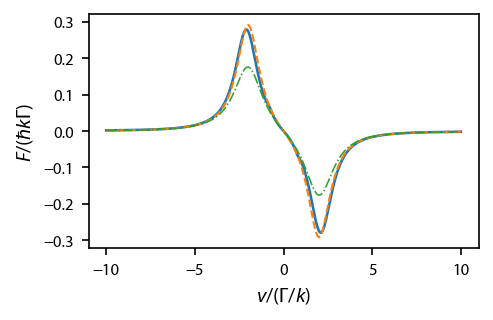

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.))
lbls = {'obe':'OBE', 'rateeq':'Rate Eq.', 'heuristiceq':'Heuristic Eq.'}
styles = ['-','--','-.']
for ii, key in enumerate(eqns):
    ax.plot(v, eqns[key].profile['molasses'].F[0], styles[ii],
            label=lbls[key], linewidth=1.25-0.25*ii)
    #ax[1].plot(v, eqn.profile['molasses'].Neq)
#ax.legend(fontsize=7)
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')
fig.subplots_adjust(bottom=0.2)
fig.savefig('two_level_molasses_forces.pdf')

For the rate equations and the OBEs, also plot up the equilibrium populations of the two states:

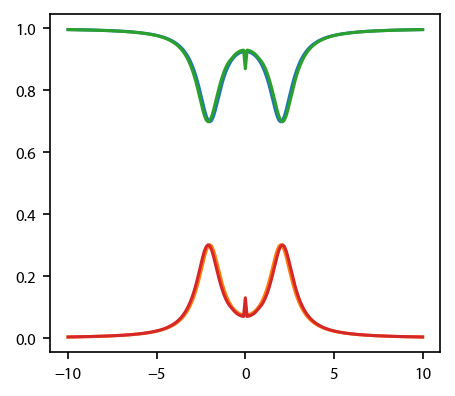

In [5]:
fig, ax = plt.subplots(1, 1)
for key in ['rateeq', 'obe']:
    #ax[0].plot(v, eqn[key].profile['molasses'].F[0])
    ax.plot(v, eqns[key].profile['molasses'].Neq)

### Let's next investigate the damping force
We calculate the damping coefficient $\beta$ as a function of $s_0$ and $\delta$, and compare to the Lett expression for the damping.

In [6]:
dv = 0.01

deltas = np.linspace(-3, 0., 101)
betas = np.array([0.01, 0.1, 1, 10])

alphas = {}
Deltas, Betas = np.meshgrid(deltas, betas)

eqns = {'heuristiceq':pylcp.heuristiceq, 'rateeq':pylcp.rateeq, 'obe':pylcp.obe}

extra_args['obe'] = {'deltat':2*np.pi*100, 'itermax':1000, 'rel':1e-4, 'abs':1e-6}
extra_args['rateeq'] = {}
extra_args['heuristiceq'] = {}

for key in eqns:
    it = np.nditer([Deltas, Betas, None])
    progress = progressBar()
    for (delta, beta, alpha) in it:
        laserBeams = return_lasers(delta, beta)
        hamiltonian = return_hamiltonian(0.)

        # Next, generate the OBE or rate equations:
        if key is 'heuristiceq':
            eqn = eqns[key](laserBeams, magField)
        else:
            eqn = eqns[key](laserBeams, magField, hamiltonian)

        eqn.set_initial_velocity(np.array([dv, 0., 0.]))
        if key is 'obe':
            eqn.set_initial_rho_equally()

        alpha[...] = -eqn.find_equilibrium_force(**extra_args[key])[0]/dv
        progress.update((it.iterindex+1)/it.itersize)
    # Just update it to be sure.
    progress.update(1.)

    alphas[key] = it.operands[2]

Completed in 0.30 s.                                              
Completed in 0.66 s.                                               
Completed in 5:04.                                                  


Plot it up:

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


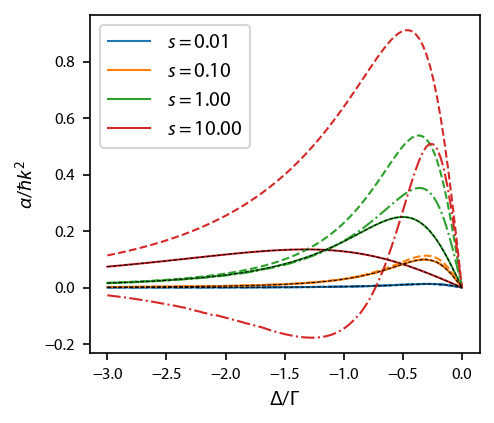

In [7]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(eqns):
    for jj, alphas_i in enumerate(alphas[key]):
        if ii==0:
            kwargs = {'label':'$s=%.2f$'%betas[jj]}
        else:
            kwargs = {}
        ax.plot(deltas, alphas_i, styles[ii], color='C%d'%jj, linewidth=1., **kwargs)
        

for ii, beta in enumerate(betas):
    ax.plot(deltas, -4*beta*2*deltas/(1+2*beta+4*deltas**2)**2, 'k--',
             linewidth=0.5)
    
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$\\alpha/\hbar k^2$')
if savefigs:
    fig.savefig('damping_force_1D_molasses.pdf')

## Now, we want to simulate a whole bunch of atoms
We'll run about $N_A=100$ for about $1000 \Gamma t$ to
generate some histograms and understand what velocities we obtain, etc.

First choose the governing equation.

Completed in 5:08.                                                  


Text(0, 0.5, '$v/(\\Gamma/k)$')

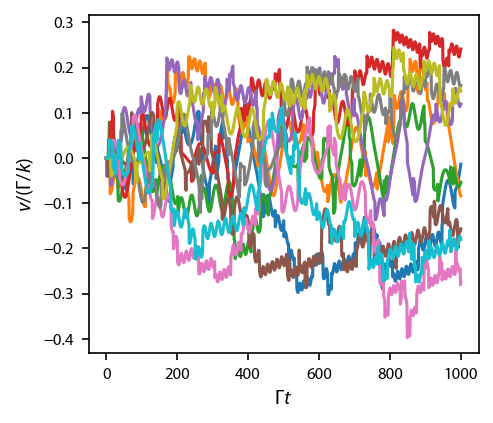

In [12]:
beta = 1.
delta = -1.5

laserBeams = return_lasers(delta, beta)
hamiltonian = return_hamiltonian(0.)

#eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
#eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
eqn = pylcp.obe(laserBeams, magField, hamiltonian)

N_atom = 100
v_final = np.zeros((N_atom,))
#num_of_scatters = np.zeros((N_atom,), dtype='int')
#num_of_steps = np.zeros((N_atom,), dtype='int')

fig, ax = plt.subplots(1, 1)
sols = []
progress = progressBar()
for ii in range(N_atom):
    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0., 0., 0.]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop_from_equilibrium()
    elif isinstance(eqn, pylcp.obe):
        eqn.set_initial_rho_from_rateeq()

    eqn.evolve_motion([0., 1000.], random_recoil=True,
                      max_scatter_probability=0.25,
                      freeze_axis=[False, True, True])
    progress.update((ii+1.)/N_atom)

    if ii<10:
        ax.plot(eqn.sol.t, eqn.sol.v[0])

    v_final[ii] = eqn.sol.v[0, -1]

    sols.append(eqn.sol)
    #num_of_scatters[ii] = sum(eqn.sol.n_random)
    #num_of_steps[ii] = len(eqn.sol.t)

ax.set_xlabel('$\Gamma t$')
ax.set_ylabel('$v/(\Gamma/k)$')

### Now, let's bin the final data and fit it up!

0.0


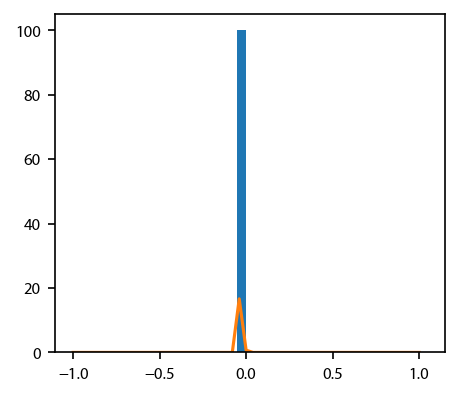

In [9]:
print(2*np.std(v_final)**2*mass)
xb = np.arange(-1., 1.1, 0.05)
fig, ax = plt.subplots(1, 1)
ax.hist(v_final, bins=xb)
x = xb[:-1] + np.diff(xb)/2
y = np.histogram(v_final, bins=xb)[0]

model = lmfit.models.GaussianModel()
result = model.fit(y, x=x)

x_fit = np.linspace(-1., 1., 51)
ax.plot(x_fit, result.eval(x=x_fit))

## Now, let's now vary the detuning and the intensity

And calculate the resulting temperature.  We can again compare to the Lett formula.

In [10]:
deltas = np.array([-3, -2., -1., -0.5, -0.375, -0.25, -0.125, 0.])
betas = np.array([0.3, 1, 3])

t0 = 500 # Evolution time at delta=-1 detuning, beta=1
Deltas, Betas = np.meshgrid(deltas, betas)

it = np.nditer([Deltas, Betas, None, None])
for (delta, beta, sigma, delta_sigma) in it:
    print('Working on delta=%.1f and beta=%.1f'%(delta, beta))
    # First, generate the new laser beams and hamiltonian:
    laserBeams = return_lasers(delta, beta)
    hamiltonian = return_hamiltonian(0.)

    # Next, generate the OBE, rate equations or heuristic eqn:
    #eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
    eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

    # Now, evolve however many times:
    progress = progressBar()
    for ii in range(N_atom):
        eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                              np.array([0., 0., 0.]))
        if isinstance(eqn, pylcp.rateeq):
            eqn.set_initial_pop_from_equilibrium()
        elif isinstance(eqn, pylcp.obe):
            eqn.set_initial_rho_from_rateeq()

        eqn.evolve_motion([0., t0*(1+2*beta+4*np.abs(delta)**2)/7/beta],
                          random_recoil=True,
                          max_scatter_probability=0.1,
                          freeze_axis=[False, True, True])

        v_final[ii] = eqn.sol.v[0, -1]
        progress.update((ii+1.)/N_atom)

    # Now bin and fit:
    xb = np.arange(-1., 1.1, 0.05)
    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]

    model = lmfit.models.GaussianModel()
    result = model.fit(y, x=x)

    sigma[...] = result.best_values['sigma']
    delta_sigma[...] = result.params['sigma'].stderr

    print('Got %.4f +/- %.4f'%(sigma, delta_sigma))

Working on delta=-3.0 and beta=0.3
Completed in 13:15.                                                 
Got 0.1505 +/- 0.0074
Working on delta=-2.0 and beta=0.3
Completed in 6:23.                                                  
Got 0.1095 +/- 0.0053
Working on delta=-1.0 and beta=0.3
Completed in 3:16.                                                  
Got 0.1198 +/- 0.0059
Working on delta=-0.5 and beta=0.3
Completed in 3:10.                                                  
Got 0.0965 +/- 0.0050
Working on delta=-0.4 and beta=0.3
Completed in 3:09.                                                  
Got 0.1102 +/- 0.0060
Working on delta=-0.2 and beta=0.3
Completed in 3:06.                                                  
Got 0.1115 +/- 0.0103
Working on delta=-0.1 and beta=0.3
Completed in 3:03.                                                  
Got 0.1382 +/- 0.0107
Working on delta=0.0 and beta=0.3
Completed in 2:59.                                                  
Got 0.2398 +/- 

Plot up the results

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


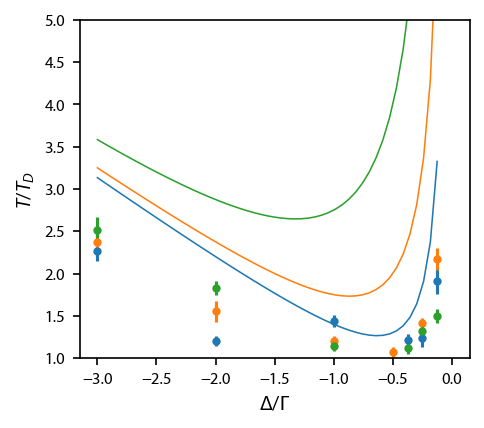

In [11]:
# %%
def lett_function(beta, delta):
    return 0.5*(1+2*beta+4*delta **2)/2/np.abs(delta)

deltas_thr = np.linspace(-3, -0.125, 51)
fig, ax = plt.subplots(1, 1)
for ii, (beta, sigmas, err) in enumerate(zip(betas, it.operands[2], it.operands[3])):
    plt.errorbar(deltas, 2*sigmas**2*mass, 2*sigmas*err*mass, fmt='.', color='C%d'%ii)
    plt.plot(deltas_thr, lett_function(beta, deltas_thr), linewidth=0.75, color='C%d'%ii)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$T/T_D$')
ax.set_ylim((1, 5))
if savefigs:
    fig.savefig('final_temperature_two_level_1D_molasses_rate_eqn.pdf')